In [40]:
from torchvision import models
import torch

resnet = models.resnet50(pretrained=True)

def extract_feature(model, x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    return x

In [41]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225])
])

In [73]:
from PIL import Image

ori_img = 'lemon.jpg'
input_img = 'original/' + ori_img
img = Image.open(input_img)
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

resnet.eval()
output = resnet(batch_t)

print(img.size)
print(img_t.shape)
print(batch_t.shape)
print(output.shape)

(700, 525)
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


In [74]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [75]:
_, index = torch.max(output, 1)
print(index)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100

print(categories[index.item()], percentage[index[0]].item())

_, indices = torch.sort(output, descending=True)
[(categories[idx.item()], percentage[idx].item()) for idx in indices[0][:5]]

tensor([951])
lemon 97.3816909790039


[('lemon', 97.3816909790039),
 ('orange', 1.8861359357833862),
 ('mixing bowl', 0.07928533107042313),
 ('mortar', 0.07187452912330627),
 ('strainer', 0.05924801900982857)]

In [76]:
fm = extract_feature(resnet, batch_t)

In [77]:
print(fm.shape)
print(index)

torch.Size([1, 2048, 7, 7])
tensor([951])


In [78]:
print(list(resnet.fc.parameters())[0][index.item()])

tensor([-0.0200,  0.0013, -0.0276,  ..., -0.0241, -0.0011,  0.0358],
       grad_fn=<SelectBackward>)


In [79]:
total = 0

for i, fmi in enumerate(fm[0]):
    weight = list(resnet.fc.parameters())[0][index.item()][i]
    total += fmi * weight

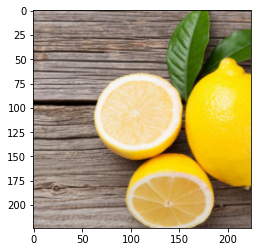

torch.Size([224, 224, 3])


In [80]:
import matplotlib.pyplot as plt
import numpy as np

# plt.imshow(np.resize(total.detach().numpy(), (976, 549)))
# plt.imshow(total.detach().numpy())
# plt.imshow(img_t.view(224,224,3))
plt.imshow(img_t := img_t.permute(1,2,0))
plt.show()
print(img_t.shape)

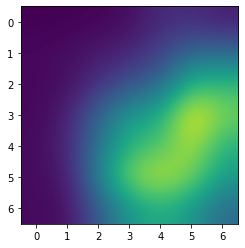

In [81]:
plt.imshow(total.detach().numpy(), interpolation='bicubic')
plt.show()

In [82]:
import cv2 as cv

heatmap = cv.resize(total.detach().numpy(), (224, 224))

max_value = np.max(heatmap)
min_value = np.min(heatmap)
normalized_heatmap = (heatmap - min_value) / (max_value - min_value)

save image: lemon.jpg


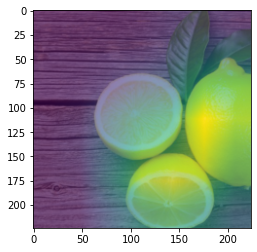

In [83]:
plt.imshow(img_t)
plt.imshow(normalized_heatmap*255, alpha=0.6)

# plt.show()
print('save image: ' + ori_img)
plt.savefig('result/CAM_' + ori_img, bbox_inches='tight', pad_inches=0.5)